In [35]:
#trying to merge again 

In [36]:
import requests
import time
import tqdm
import pandas as pd
import os
import json
import openpyxl 
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import NaN
import seaborn as sns
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from matplotlib.patches import Circle

In [37]:
fp_data = Path.cwd() / "data" 
Path.mkdir(fp_data, exist_ok=True)  
print(fp_data)

C:\Users\Bruger\OneDrive\Dokumenter\GitHub\isds2023\assignments\exam_project_2\data


In [38]:
file_path= fp_data / 'combined_data.csv'
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

In [39]:
#rename columns
df.columns= ['type and adress', 'price', 'date and type', 'm2 and kr/m2', 'rooms', 'year built', 'difference', 'idk'] 

In [40]:

#clean the data 
df['address'] = df['type and adress'].apply(lambda x: x.split("EEjerlejlighed", 1)[-1].strip())
df.drop('type and adress', axis=1, inplace=True) 
df['date']=df['date and type'].apply(lambda x: x.split("Alm.", 1)[0].strip())
df.drop('date and type', axis=1, inplace=True) 

df['kr/m2']=df['m2 and kr/m2'].apply(lambda x: x.split('m²', 1)[-1].strip())
df['kr/m2']= df['kr/m2'].str[:-5]

df['m2']=df['m2 and kr/m2'].apply(lambda x: x.split('m²', 1)[0].strip())

df['price']= df['price'].str[:-3]
df['price'] = df['price'].apply(lambda x: int(re.sub(r'\D', '', x)))
df['price']=df['price'].astype(int)

#define date values 
df['datetime'] = pd.to_datetime(df['date'], format = '%d-%m-%Y')
df['year']= df['datetime'].dt.year
#df['month']= df['datetime'].dt.month
df['quarter']=df['datetime'].dt.quarter

#define quarter + year function 
df['year + quarter'] = df['year'].astype(str) + 'K' + df['quarter'].astype(str)
#define year + month function 
# df['year + month'] = df['year'].astype(str) + df['month'].astype(str) 

#drop values
df.drop('difference', axis=1, inplace=True)
df.drop('idk', axis=1, inplace=True) 
df.drop('year', axis=1, inplace=True)
df.drop('quarter', axis=1, inplace=True)
#df.drop('month', axis=1, inplace=True) 
df.drop('m2 and kr/m2', axis=1, inplace=True)

# Regular expression pattern for Danish postal codes
pattern = r'\b\d{4}\b'
# Extract postal codes using regular expressions
df['postal_code'] = df['address'].apply(lambda x: re.search(pattern, x).group() if re.search(pattern, x) else None)

In [41]:
#convert to intengers 
df['kr/m2'] = df['kr/m2'].astype(str).apply(lambda x: int(re.sub(r'\D', '', x)))
df['kr/m2']=df['kr/m2'].astype(int)

In [42]:
#check if there are any missing values 
missing_values = df.isnull().sum()
missing_values
#there are none

price             0
rooms             0
year built        0
address           0
date              0
kr/m2             0
m2                0
datetime          0
year + quarter    0
postal_code       0
dtype: int64

In [43]:
#looking at the data 
df_1 = df.sort_values(by='price', ascending=True)
df_1.to_csv('sorted_df.csv', index=False)


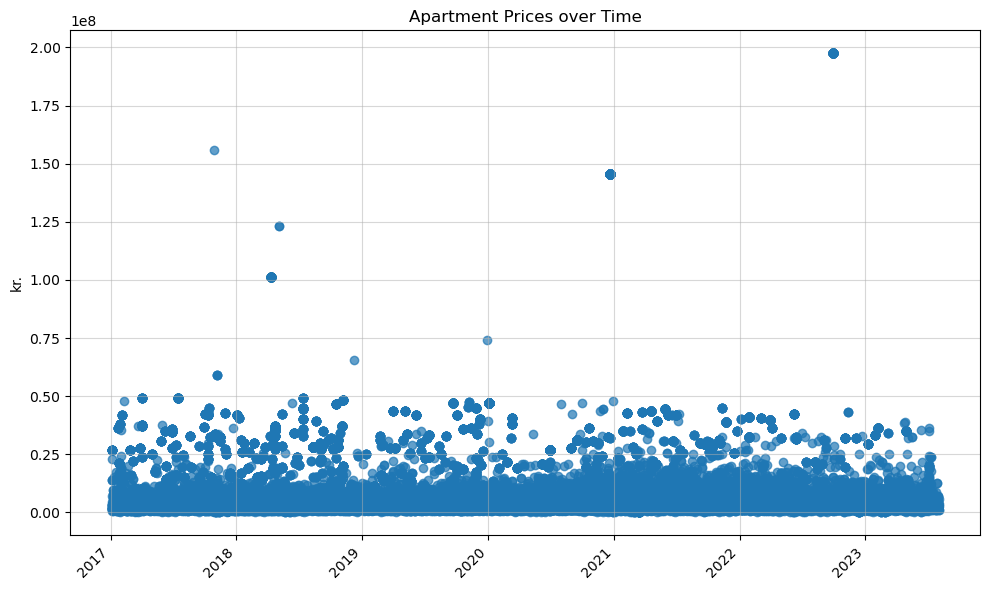

<Figure size 640x480 with 0 Axes>

In [44]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(df_1['datetime'], df_1['price'], marker='o', alpha=0.7)
plt.title('Apartment Prices over Time')
plt.ylabel('kr.')
ax.grid(True, alpha=0.5)
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.tight_layout()
plt.show()
plt.savefig('df_1.png', dpi=300)

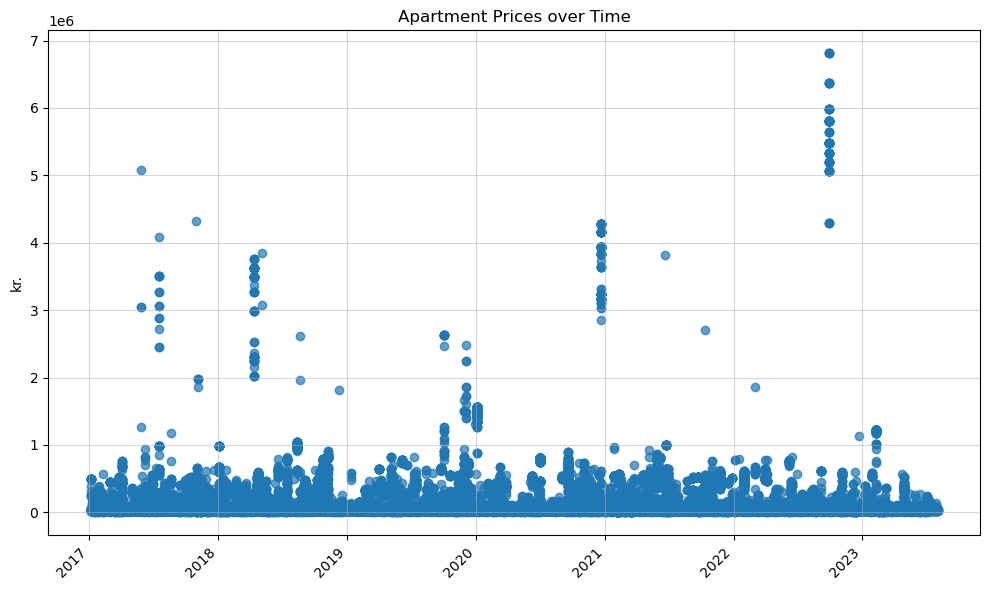

In [45]:
#Need to further clean the data
# plot by square meter
# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(df_1['datetime'], df_1['kr/m2'], marker='o', alpha=0.7)
plt.title('Apartment Prices over Time')
plt.ylabel('kr.')
ax.grid(True, alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()




In [46]:
#Removing outliars 
cleaned_data_set = df[df['kr/m2'] > 1000000].groupby(['datetime', 'price']).size().reset_index(name='count')
cleaned_data_set = cleaned_data_set[cleaned_data_set['count'] > 1]

#Remove values 
# Merge the two DataFrames
merged_data = pd.merge(df, cleaned_data_set, on=['datetime', 'price'], how='left', indicator=True)

# Filter out rows from merged_data that are in the result DataFrame
filtered_data_to_remove = merged_data[merged_data['_merge'] == 'left_only']

# Drop the indicator column
filtered_data_to_remove.drop('_merge', axis=1, inplace=True)

df_2=filtered_data_to_remove.drop(columns='count')

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\3606448427.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_to_remove.drop('_merge', axis=1, inplace=True)


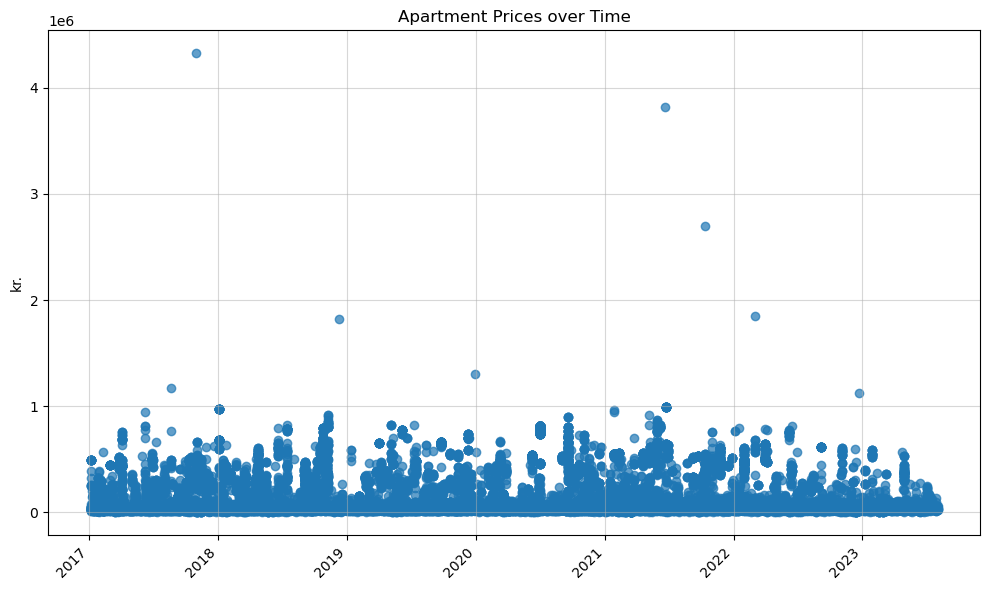

In [47]:
#Need to further clean the data
# plot by square meter
# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(df_2['datetime'], df_2['kr/m2'], marker='o', alpha=0.7)
plt.title('Apartment Prices over Time')
plt.ylabel('kr.')
ax.grid(True, alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()




In [48]:
#further removing impossible values 
#day, room numbers, year built, datetime, postalcode 
#price above 30 million
#Removing outliars 
df_3 = df_2[df_2['price'] > 2500000].groupby(['datetime', 'price', 'postal_code', 'year built']).size().reset_index(name='count')
df_4 = df_3[df_3['count'] > 1]

In [49]:
merged_data_2 = pd.merge(df_2, df_4, on=['datetime', 'price'], how='left', indicator=False)
merged_data_2 = merged_data_2.fillna(1)

df_5 = merged_data_2[merged_data_2['count'] == 1]
df_5.drop('postal_code_y', axis=1, inplace=True)
df_5.drop('year built_y', axis=1, inplace=True) 

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\1631703866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.drop('postal_code_y', axis=1, inplace=True)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\1631703866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.drop('year built_y', axis=1, inplace=True)


In [50]:
df_5.drop('count', axis=1, inplace=True) 

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\1396983221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.drop('count', axis=1, inplace=True)


In [51]:
df_5.rename(columns={'year built_x': 'year built'}, inplace=True)
df_5.rename(columns={'postal_code_x': 'postal_code'}, inplace=True)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\2189968032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.rename(columns={'year built_x': 'year built'}, inplace=True)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\2189968032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5.rename(columns={'postal_code_x': 'postal_code'}, inplace=True)


In [52]:
#remove last outliars manually
sorted_2=df_5.sort_values(by='price', ascending=True)
df_5=df_5[df_5['price'] < 65531258]

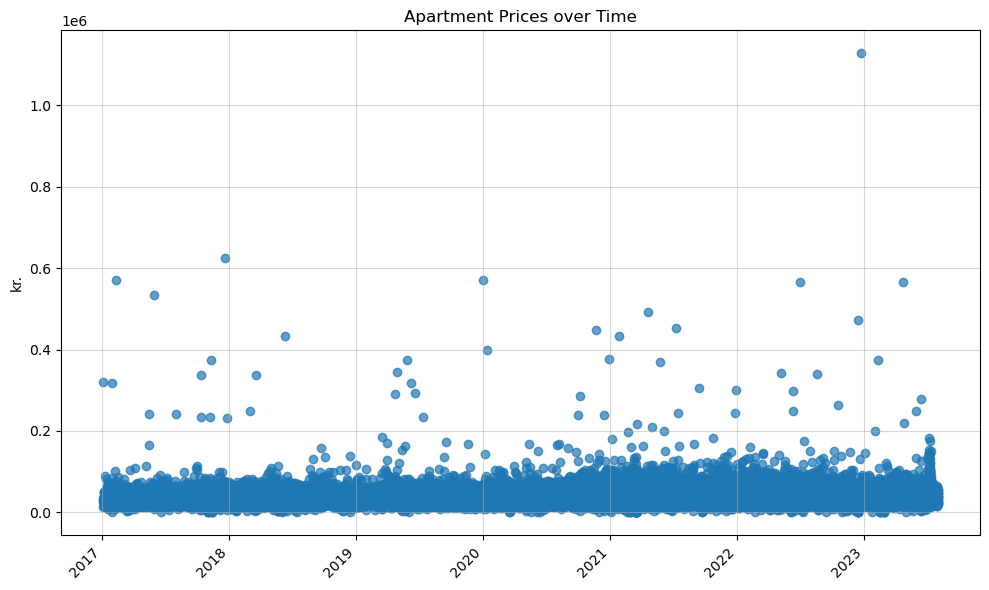

In [53]:
#final plot 
# plot by square meter
# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(df_5['datetime'], df_5['kr/m2'], marker='o', alpha=0.7)
plt.title('Apartment Prices over Time')
plt.ylabel('kr.')
ax.grid(True, alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()




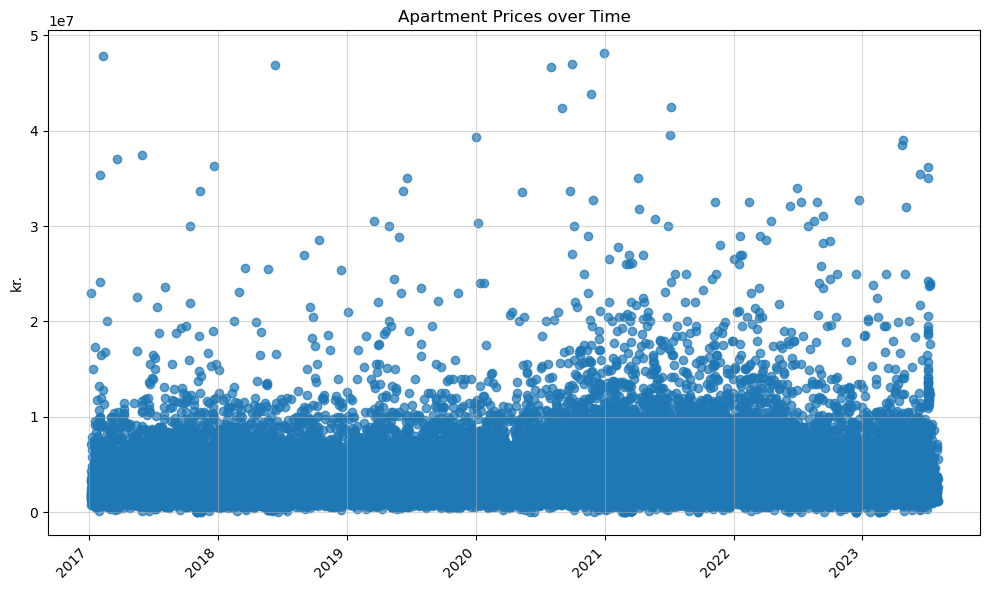

In [54]:
#final plot with price
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(df_5['datetime'], df_5['price'], marker='o', alpha=0.7)
plt.title('Apartment Prices over Time')
plt.ylabel('kr.')
ax.grid(True, alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [55]:
def construct_link(table_id, variables):
    base = f'https://api.statbank.dk/v1/data/{table_id}/JSONSTAT?lang=en'
    
    for var in variables:
        base += f'&{var}'

    return base 

construct_link('MPK3', ['Tid=*', 'Type=5500602011'])
#API FOR loan interest rate 
#It refers to the interest rate that banks and financial institutions charge for lending money to individuals, businesses, and other institutions.
url = construct_link('MPK3', ['Tid=*', 'Type=5500602011'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

Interest_rate = create_data(url)

interest_rate_df = pd.DataFrame(Interest_rate.items(), columns=['Year', 'Loan interest rate']).dropna()

interest_rate_df['datetime'] = pd.to_datetime(interest_rate_df['Year'], format = '%YM%m')
interest_rate_df['year']= interest_rate_df['datetime'].dt.year
interest_rate_df['quarter']=interest_rate_df['datetime'].dt.quarter
#interest_rate_df['month'] = interest_rate_df['datetime'].dt.month
interest_rate_df['year + quarter'] = interest_rate_df['year'].astype(str) + 'K' + interest_rate_df['quarter'].astype(str)
interest_rate_df.set_index('year + quarter', inplace=True)

interest_rate_df.drop('Year', axis=1, inplace=True)
interest_rate_df.drop('year', axis=1, inplace=True)
interest_rate_df.drop('quarter', axis=1, inplace=True)
interest_rate_df.drop('datetime', axis=1, inplace=True)

In [56]:
interest_rate_df

,Loan interest rate
year + quarter,
1988K1,0.00
1988K1,0.00
1988K1,0.00
1988K2,0.00
1988K2,0.00
...,...
2023K1,2.75
2023K2,2.75
2023K2,3.00


In [57]:
interest_rate_df = interest_rate_df.groupby('year + quarter')['Loan interest rate'].mean().reset_index()

In [58]:
interest_rate_df.set_index('year + quarter', inplace=True)

In [59]:
df_5.set_index('year + quarter', inplace=True)

In [60]:
df_5

,price,rooms,year built,address,date,kr/m2,m2,datetime,postal_code
year + quarter,,,,,,,,,
2023K3,2650000,1,1975,"Søndre Fasanvej 94C, st. 49 2500 Valby",02-08-2023,39552,67,2023-08-02,2500
2023K3,1153000,1,1962,"Herlev Bygade 2, 1. 4 2730 Herlev",02-08-2023,23531,49,2023-08-02,2730
2023K3,1175000,2,1943,"Christoffers Alle 70, st. 2 2800 Kongens Lyngby",02-08-2023,27976,42,2023-08-02,2800
2023K3,3451000,4,2007,"Gyngemose Parkvej 12, 2. tv 2860 Søborg",02-08-2023,35577,97,2023-08-02,2860
2023K3,5550000,3,2021,"Strandlodsvej 23G, 7. th 2300 København S",02-08-2023,56061,99,2023-08-02,2300
...,...,...,...,...,...,...,...,...,...
2017K1,1600000,4,1972,"Saksen C 4, st. 4 2630 Taastrup",04-01-2017,13793,116,2017-01-04,2630
2017K1,3275000,4,2000,"Engvej 40, st. tv 2791 Dragør",04-01-2017,31190,105,2017-01-04,2791
2017K1,1458000,2,1975,"Hamletsgade 4, 4. 198 2200 København N",04-01-2017,25138,58,2017-01-04,2200


In [61]:
df_6=df_5.join(interest_rate_df)

In [62]:
#monthly inflation: percentage monthly change in consumer price index
url = construct_link('PRIS111', ['Tid=*', 'VAREGR=000000', 'Enhed=200'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

Inflation = create_data(url)
Inflation_df = pd.DataFrame(Inflation.items(), columns=['Year', 'Inflation']).dropna()

Inflation_df['datetime'] = pd.to_datetime(Inflation_df['Year'], format = '%YM%m')
#Inflation_df['month'] = Inflation_df['datetime'].dt.month
Inflation_df['year']= Inflation_df['datetime'].dt.year
Inflation_df['quarter']=Inflation_df['datetime'].dt.quarter

Inflation_df['year + quarter'] = Inflation_df['year'].astype(str) + 'K' + Inflation_df['quarter'].astype(str)
# Inflation_df['year + month'] = Inflation_df['year'].astype(str) + Inflation_df['month'].astype(str)

Inflation_df.drop('datetime', axis=1, inplace=True)
#Inflation_df.drop('month', axis=1, inplace=True)
Inflation_df.drop('Year', axis=1, inplace=True)
Inflation_df.drop('quarter', axis=1, inplace=True)
Inflation_df.drop('year', axis=1, inplace=True)

Inflation_df = Inflation_df.groupby('year + quarter')['Inflation'].mean().reset_index()
Inflation_df.set_index('year + quarter', inplace=True)

In [63]:
df_7=df_6.join(Inflation_df)

In [64]:
df_7

,price,rooms,year built,address,date,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation
year + quarter,,,,,,,,,,,
2017K1,1775000,3,1966,"Vejlegårdsparken 40, st. 7 2665 Vallensbæk Strand",31-03-2017,20640,86,2017-03-31,2665,0.05,0.3
2017K1,1440000,2,1962,"Rødovre Parkvej 281, 1 2610 Rødovre",30-03-2017,23607,61,2017-03-30,2610,0.05,0.3
2017K1,4495000,5,1885,"Kroghsgade 5, st. th 2100 København Ø",30-03-2017,40864,110,2017-03-30,2100,0.05,0.3
2017K1,1800000,4,1912,"Jagtvej 187, st. tv 2100 København Ø",30-03-2017,18367,98,2017-03-30,2100,0.05,0.3
2017K1,1375000,3,1963,"Brinchs Have 13, st. tv 2630 Taastrup",30-03-2017,19643,70,2017-03-30,2630,0.05,0.3
...,...,...,...,...,...,...,...,...,...,...,...
2023K3,16449501,4,2023,"Papirøen 51, 6. 1 1436 København K",02-07-2023,132657,124,2023-07-02,1436,3.50,1.8
2023K3,800000,4,1918,"Hollænderdybet 2, 2. th 2300 København S",02-07-2023,8511,94,2023-07-02,2300,3.50,1.8
2023K3,2700000,2,1968,"Holmbladsgade 94, 2. 26 2300 København S",01-07-2023,36986,73,2023-07-01,2300,3.50,1.8


In [65]:
#API for salary (this one is quarterly) 
#Standardised index of average earnings (2016=100) 

url = construct_link('SBLON1', ['Tid=*', 'BRANCHE07=*', 'VARIA1=100', 'SEKTOR=1000'])
def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

salary_df = create_data(url)

# Create a DataFrame
salary_df = pd.DataFrame(salary_df.items(), columns=['year + quarter', 'Salary']).dropna()
salary_df.set_index('year + quarter', inplace=True)

In [66]:
df_8=df_7.join(salary_df)

In [67]:
#API for GDP (are we in an economic boom --> could maybe create a binary variable with a yes or no) 
#chose to use chained values because account for changes in price levels over time, making them suitable for comparing economic 
#data across different time periods while adjusting for inflation or deflation. This is important because GDP and housing prices 
#can be affected by changes in the general price level, and using chained values helps to isolate the real changes in these variables.

url = construct_link('NKN1', ['Tid=*', 'S%C3%86SON=*', 'PRISENHED=LKV_M', 'TRANSAKT=B1GQK'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

gdp= create_data(url)
gdp_df = pd.DataFrame(gdp.items(), columns=['year + quarter', 'GDP']).dropna()
gdp_df.set_index('year + quarter', inplace=True)



In [68]:
df_9=df_8.join(gdp_df)

In [69]:
df_9

,price,rooms,year built,address,date,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP
year + quarter,,,,,,,,,,,,,
2017K1,1775000,3,1966,"Vejlegårdsparken 40, st. 7 2665 Vallensbæk Strand",31-03-2017,20640,86,2017-03-31,2665,0.05,0.3,100.8,495.4
2017K1,1440000,2,1962,"Rødovre Parkvej 281, 1 2610 Rødovre",30-03-2017,23607,61,2017-03-30,2610,0.05,0.3,100.8,495.4
2017K1,4495000,5,1885,"Kroghsgade 5, st. th 2100 København Ø",30-03-2017,40864,110,2017-03-30,2100,0.05,0.3,100.8,495.4
2017K1,1800000,4,1912,"Jagtvej 187, st. tv 2100 København Ø",30-03-2017,18367,98,2017-03-30,2100,0.05,0.3,100.8,495.4
2017K1,1375000,3,1963,"Brinchs Have 13, st. tv 2630 Taastrup",30-03-2017,19643,70,2017-03-30,2630,0.05,0.3,100.8,495.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023K3,16449501,4,2023,"Papirøen 51, 6. 1 1436 København K",02-07-2023,132657,124,2023-07-02,1436,3.50,1.8,NaN,NaN
2023K3,800000,4,1918,"Hollænderdybet 2, 2. th 2300 København S",02-07-2023,8511,94,2023-07-02,2300,3.50,1.8,NaN,NaN
2023K3,2700000,2,1968,"Holmbladsgade 94, 2. 26 2300 København S",01-07-2023,36986,73,2023-07-01,2300,3.50,1.8,NaN,NaN


In [70]:
df_9=df_9.dropna()
df_9.drop('date', axis=1, inplace=True) 
#set everything as floats 
df_9['postal_code']=df_9['postal_code'].astype(float)
df_9['rooms']=df_9['rooms'].astype(float)
df_9['price']=df_9['price'].astype(float)
df_9['year built']=df_9['year built'].astype(float)
df_9['kr/m2']=df_9['kr/m2'].astype(float)
df_9['m2']=df_9['m2'].astype(float)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\4254065937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9.drop('date', axis=1, inplace=True)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\4254065937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9['postal_code']=df_9['postal_code'].astype(float)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\4254065937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [71]:
df_9

,price,rooms,year built,address,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP
year + quarter,,,,,,,,,,,,
2017K1,1775000.0,3.0,1966.0,"Vejlegårdsparken 40, st. 7 2665 Vallensbæk Strand",20640.0,86.0,2017-03-31,2665.0,0.05,0.300000,100.8,495.4
2017K1,1440000.0,2.0,1962.0,"Rødovre Parkvej 281, 1 2610 Rødovre",23607.0,61.0,2017-03-30,2610.0,0.05,0.300000,100.8,495.4
2017K1,4495000.0,5.0,1885.0,"Kroghsgade 5, st. th 2100 København Ø",40864.0,110.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4
2017K1,1800000.0,4.0,1912.0,"Jagtvej 187, st. tv 2100 København Ø",18367.0,98.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4
2017K1,1375000.0,3.0,1963.0,"Brinchs Have 13, st. tv 2630 Taastrup",19643.0,70.0,2017-03-30,2630.0,0.05,0.300000,100.8,495.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2023K1,2700000.0,2.0,1990.0,"Allersgade 2, 2. mf 2200 København N",38571.0,70.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0
2023K1,8900000.0,4.0,1904.0,"Sankt Thomas Alle 9, 4. tv 1824 Frederiksberg C",86408.0,103.0,2023-01-01,1824.0,2.30,0.366667,115.3,558.0
2023K1,2995000.0,4.0,1946.0,"Smakkegårdsvej 169, 1. tv 2820 Gentofte",32912.0,91.0,2023-01-01,2820.0,2.30,0.366667,115.3,558.0


In [72]:
#create categorization of postal_codes

url = 'https://peters1.dk/postnummer/' 

# Connects to site
response = requests.get(url)

# Parse data with BeautifulSoup
soup = BeautifulSoup(response.content,'lxml')

# Identify table to scrape by inspecting site
table_node = soup.find(id = 'myTable')


url = 'https://peters1.dk/postnummer/'

# Connects to site
response = requests.get(url)

# Parse data with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Identify table to scrape by inspecting site
table_node = soup.find(id='myTable')

# Extract table rows
rows = table_node.find_all('tr')

# Initialize lists to store data
data = []
columns = ['Postnr.', 'Bynavn', 'Gade']

# Loop through rows to extract data
for row in rows[1:]:  # Skip the first row (header)
    cols = row.find_all('td')
    row_data = [col.text.strip() for col in cols]
    data.append(row_data)

# Create a pandas DataFrame
post_number = pd.DataFrame(data, columns=columns)

post_number.columns= ['postal_code', 'city_name', 'Gade'] 
post_number.drop('Gade', axis=1, inplace=True)

In [73]:
post_number['postal_code'] = post_number['postal_code'].astype(float)

In [74]:
post_number['category'] = post_number['city_name'].astype('category')

In [75]:
df_10= df_9.merge(post_number, on='postal_code', how='left')

In [76]:
df_11=df_10.dropna()

In [77]:
#we drop duplicates to get rid of the last double observations 
df_11=df_11.drop_duplicates()


In [78]:
df_11.reset_index(drop=True)

,price,rooms,year built,address,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP,city_name,category
0,1775000.0,3.0,1966.0,"Vejlegårdsparken 40, st. 7 2665 Vallensbæk Strand",20640.0,86.0,2017-03-31,2665.0,0.05,0.300000,100.8,495.4,Vallensbæk Strand,Vallensbæk Strand
1,1440000.0,2.0,1962.0,"Rødovre Parkvej 281, 1 2610 Rødovre",23607.0,61.0,2017-03-30,2610.0,0.05,0.300000,100.8,495.4,Rødovre,Rødovre
2,4495000.0,5.0,1885.0,"Kroghsgade 5, st. th 2100 København Ø",40864.0,110.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,København Ø,København Ø
3,1800000.0,4.0,1912.0,"Jagtvej 187, st. tv 2100 København Ø",18367.0,98.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,København Ø,København Ø
4,1375000.0,3.0,1963.0,"Brinchs Have 13, st. tv 2630 Taastrup",19643.0,70.0,2017-03-30,2630.0,0.05,0.300000,100.8,495.4,Taastrup,Taastrup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53012,2700000.0,2.0,1990.0,"Allersgade 2, 2. mf 2200 København N",38571.0,70.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,København N,København N
53013,8900000.0,4.0,1904.0,"Sankt Thomas Alle 9, 4. tv 1824 Frederiksberg C",86408.0,103.0,2023-01-01,1824.0,2.30,0.366667,115.3,558.0,Frederiksberg C,Frederiksberg C
53014,2995000.0,4.0,1946.0,"Smakkegårdsvej 169, 1. tv 2820 Gentofte",32912.0,91.0,2023-01-01,2820.0,2.30,0.366667,115.3,558.0,Gentofte,Gentofte
53015,2580000.0,2.0,1902.0,"Ægirsgade 37, 4. tv 2200 København N",51600.0,50.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,København N,København N


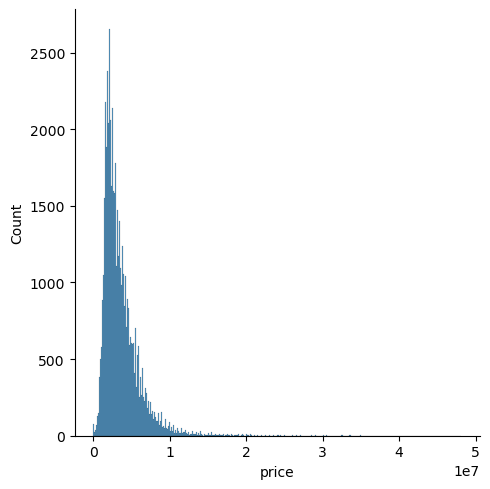

In [79]:
sns.displot(df_11['price'])

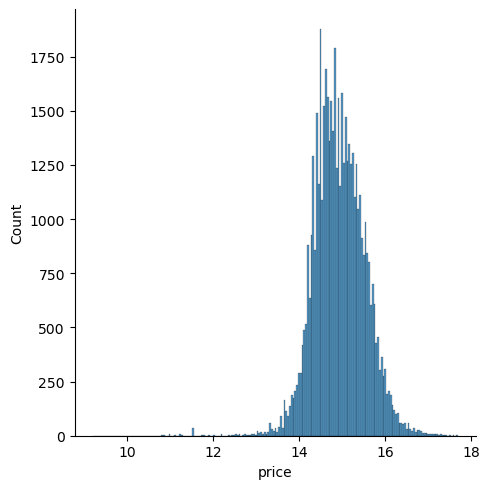

In [80]:
#convert to log 
sns.displot(np.log(df_11['price']))
plt.show()

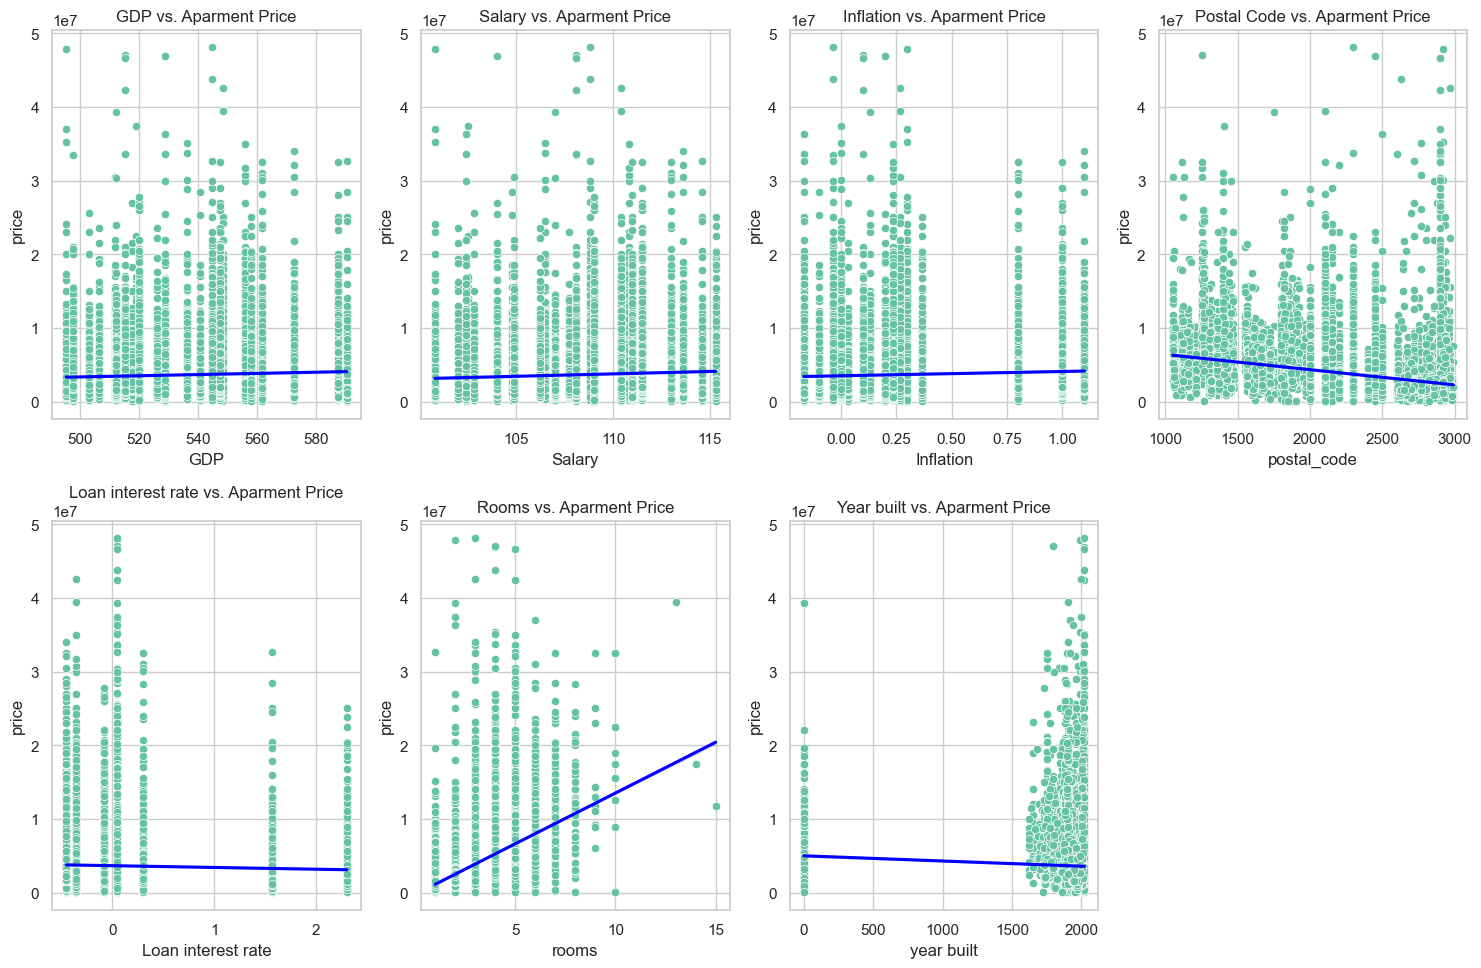

<Figure size 640x480 with 0 Axes>

In [81]:
sns.set(style="whitegrid")
sns.set_palette("Set2")

# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Create scatter plots with lines and customize each subplot
scatter_plot = sns.scatterplot(data=df_11, x='GDP', y='price', ax=axes[0, 0])
scatter_plot.set(title='GDP vs. Aparment Price')
scatter_plot.set_xlabel('GDP')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='GDP', y='price', ax=axes[0, 0], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='Salary', y='price', ax=axes[0, 1])
scatter_plot.set(title='Salary vs. Aparment Price')
scatter_plot.set_xlabel('GDP')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Salary', y='price', ax=axes[0, 1], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='Inflation', y='price', ax=axes[0, 2])
scatter_plot.set(title='Inflation vs. Aparment Price')
scatter_plot.set_xlabel('Inflation')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Inflation', y='price', ax=axes[0, 2], scatter=False, color='blue')


scatter_plot = sns.scatterplot(data=df_11, x='Loan interest rate', y='price', ax=axes[1, 0])
scatter_plot.set(title='Loan interest rate vs. Aparment Price')
scatter_plot.set_xlabel('Loan interest rate')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Loan interest rate', y='price', ax=axes[1, 0], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='rooms', y='price', ax=axes[1, 1])
scatter_plot.set(title='Rooms vs. Aparment Price')
scatter_plot.set_xlabel('Rooms')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='rooms', y='price', ax=axes[1, 1], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='year built', y='price', ax=axes[1, 2])
scatter_plot.set(title='Year built vs. Aparment Price')
scatter_plot.set_xlabel('Year built')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='year built', y='price', ax=axes[1, 2], scatter=False, color='blue')


scatter_plot = sns.scatterplot(data=df_11, x='postal_code', y='price', ax=axes[0, 3])
scatter_plot.set(title='Postal Code vs. Aparment Price')
scatter_plot.set_xlabel('Postal code')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='postal_code', y='price', ax=axes[0, 3], scatter=False, color='blue')

axes[1,3].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()
plt.savefig('scatter_plots.png', dpi=300)

In [82]:
#notice that year built is zero so further clean the data 
df_11['year built'] = df_11['year built'].replace(0, df_11[df_11['year built'] > 0]['year built'].mean())

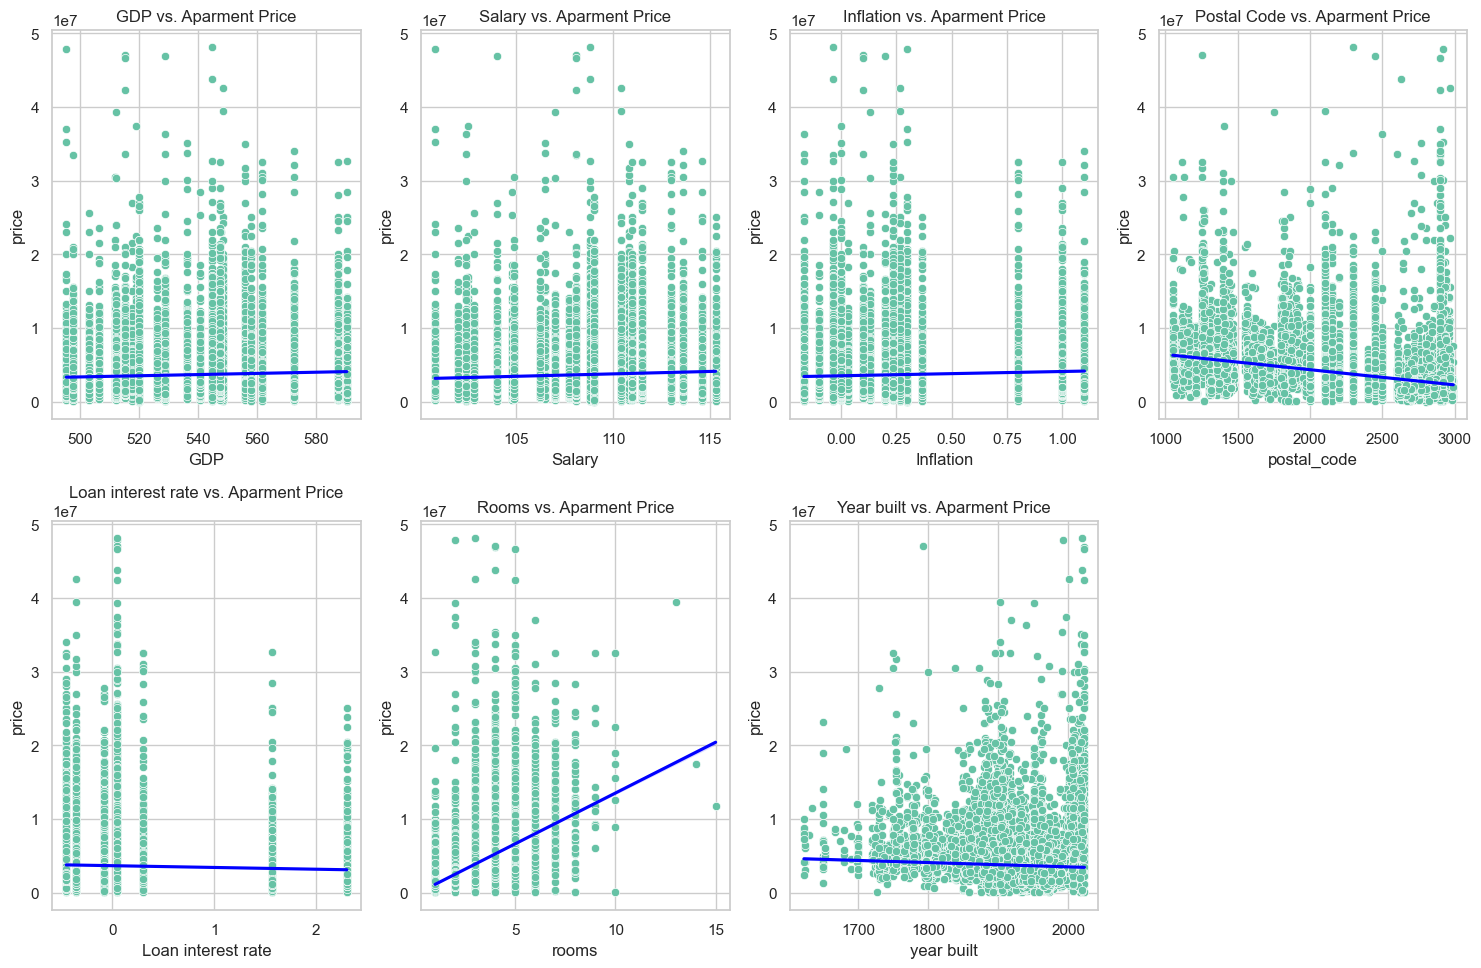

<Figure size 640x480 with 0 Axes>

In [83]:

sns.set(style="whitegrid")
sns.set_palette("Set2")

# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

# Create scatter plots with lines and customize each subplot
scatter_plot = sns.scatterplot(data=df_11, x='GDP', y='price', ax=axes[0, 0])
scatter_plot.set(title='GDP vs. Aparment Price')
scatter_plot.set_xlabel('GDP')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='GDP', y='price', ax=axes[0, 0], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='Salary', y='price', ax=axes[0, 1])
scatter_plot.set(title='Salary vs. Aparment Price')
scatter_plot.set_xlabel('GDP')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Salary', y='price', ax=axes[0, 1], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='Inflation', y='price', ax=axes[0, 2])
scatter_plot.set(title='Inflation vs. Aparment Price')
scatter_plot.set_xlabel('Inflation')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Inflation', y='price', ax=axes[0, 2], scatter=False, color='blue')


scatter_plot = sns.scatterplot(data=df_11, x='Loan interest rate', y='price', ax=axes[1, 0])
scatter_plot.set(title='Loan interest rate vs. Aparment Price')
scatter_plot.set_xlabel('Loan interest rate')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='Loan interest rate', y='price', ax=axes[1, 0], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='rooms', y='price', ax=axes[1, 1])
scatter_plot.set(title='Rooms vs. Aparment Price')
scatter_plot.set_xlabel('Rooms')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='rooms', y='price', ax=axes[1, 1], scatter=False, color='blue')

scatter_plot = sns.scatterplot(data=df_11, x='year built', y='price', ax=axes[1, 2])
scatter_plot.set(title='Year built vs. Aparment Price')
scatter_plot.set_xlabel('Year built')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='year built', y='price', ax=axes[1, 2], scatter=False, color='blue')


scatter_plot = sns.scatterplot(data=df_11, x='postal_code', y='price', ax=axes[0, 3])
scatter_plot.set(title='Postal Code vs. Aparment Price')
scatter_plot.set_xlabel('Postal code')
scatter_plot.set_ylabel('Price')
sns.regplot(data=df_11, x='postal_code', y='price', ax=axes[0, 3], scatter=False, color='blue')

axes[1,3].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()
plt.savefig('scatter_plots.png', dpi=300)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_5768\236234671.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_11.corr(), annot= True, cmap= 'coolwarm', fmt= '.2f', vmin= -1, vmax= 1)


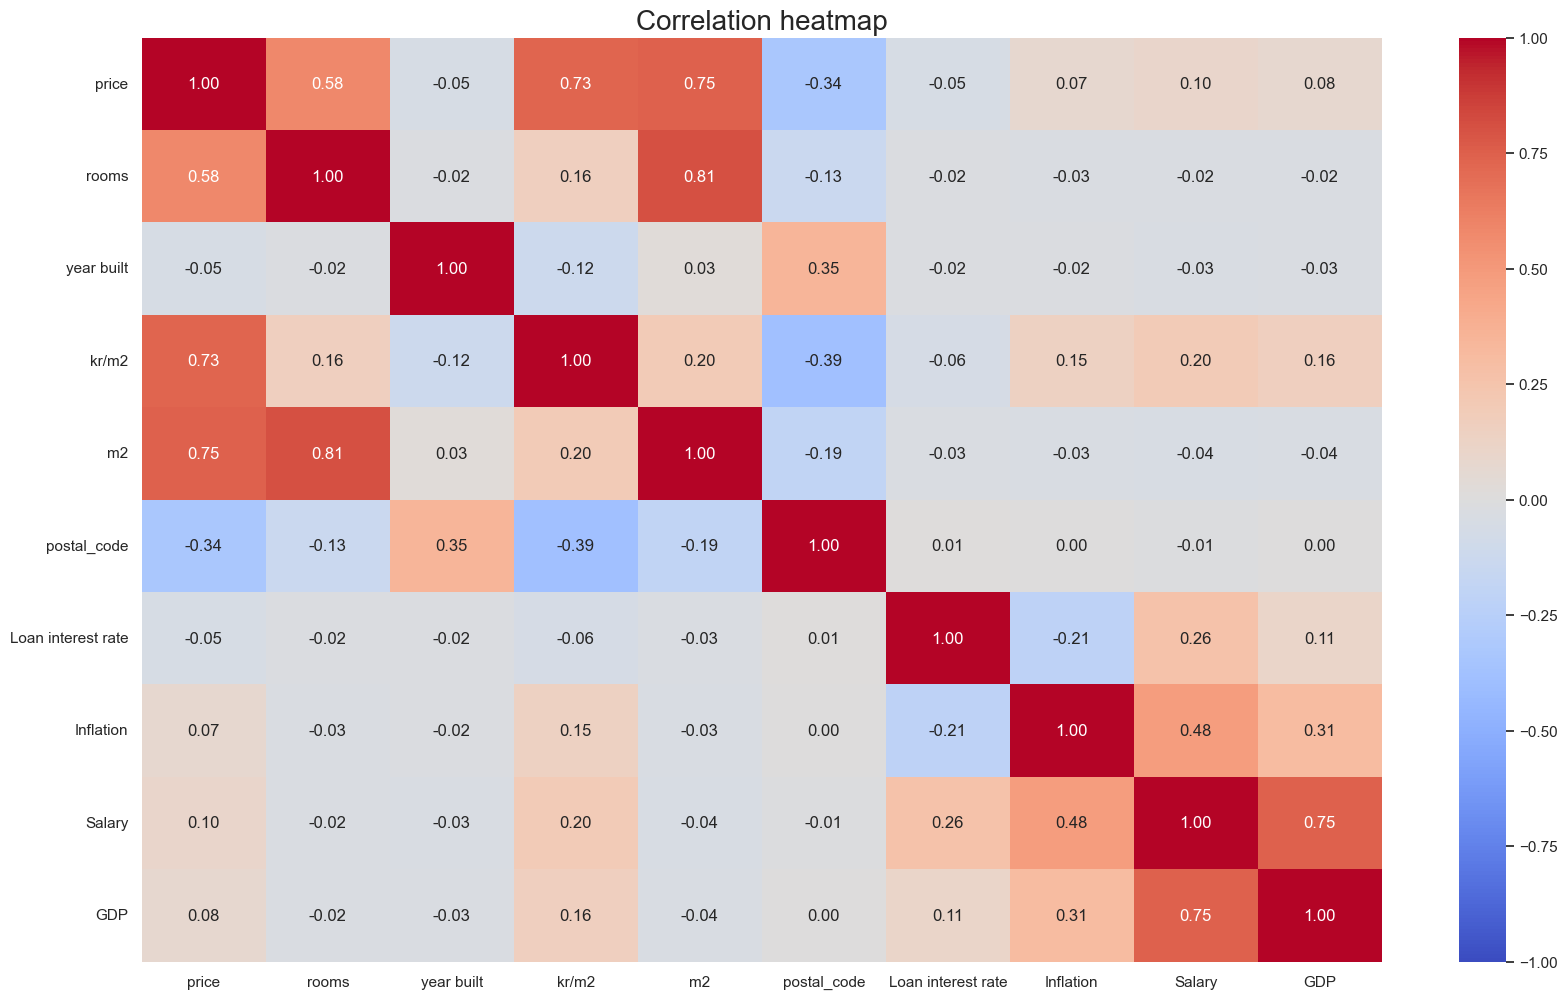

<Figure size 640x480 with 0 Axes>

In [84]:
#Correlation map 
plt.figure(figsize = (20, 12))
sns.heatmap(df_11.corr(), annot= True, cmap= 'coolwarm', fmt= '.2f', vmin= -1, vmax= 1)
plt.title('Correlation heatmap', fontsize=20)
plt.show()
plt.savefig('heatmap', dpi=300)

In [85]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_12= df_11

In [86]:
df_12.sort_values(by='postal_code', ascending=True)

,price,rooms,year built,address,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP,city_name,category
57918,7500000.0,2.0,1900.0,"Nyhavn 31E, 1. 4 1051 København K",74257.0,101.0,2021-10-29,1051.0,-0.450000,2.333333e-01,111.0,587.5,København K,København K
30411,13250000.0,2.0,1780.0,"Nyhavn 12C, st 1051 København K",70106.0,189.0,2020-09-20,1051.0,0.050000,1.000000e-01,108.1,515.4,København K,København K
65152,19500000.0,3.0,1683.0,"Nyhavn 29, 1 1051 København K",98485.0,198.0,2022-09-21,1051.0,0.300000,8.000000e-01,113.0,561.8,København K,København K
47765,14800000.0,5.0,1770.0,"Nyhavn 16, 3 1051 København K",70476.0,185.0,2021-05-19,1051.0,-0.350000,2.333333e-01,110.8,555.8,København K,København K
61444,19500000.0,7.0,1880.0,"Nyhavn 38, 5. tv 1051 København K",65878.0,296.0,2022-01-25,1051.0,-0.450000,1.000000e+00,111.5,547.5,København K,København K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21219,1320000.0,3.0,1971.0,"Langelunden 5, 2. tv 2990 Nivå",15349.0,86.0,2019-08-22,2990.0,0.050000,-1.850372e-17,106.2,526.0,Nivå,Nivå
65380,1895000.0,4.0,1971.0,"Langelunden 1, 2. th 2990 Nivå",18578.0,102.0,2022-09-11,2990.0,0.300000,8.000000e-01,113.0,561.8,Nivå,Nivå
42339,1275000.0,3.0,1971.0,"Langelunden 8, st. th 2990 Nivå",13564.0,94.0,2021-02-14,2990.0,-0.083333,3.000000e-01,109.0,520.1,Nivå,Nivå
57604,1845000.0,3.0,1971.0,"Langelunden 3, 3. tv 2990 Nivå",21453.0,86.0,2021-11-07,2990.0,-0.450000,2.333333e-01,111.0,587.5,Nivå,Nivå


In [87]:
df_12['category']=label_encoder.fit_transform(df_12['category'])

In [88]:
df_12

,price,rooms,year built,address,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP,city_name,category
0,1775000.0,3.0,1966.000000,"Vejlegårdsparken 40, st. 7 2665 Vallensbæk Strand",20640.0,86.0,2017-03-31,2665.0,0.05,0.300000,100.8,495.4,Vallensbæk Strand,47
1,1440000.0,2.0,1962.000000,"Rødovre Parkvej 281, 1 2610 Rødovre",23607.0,61.0,2017-03-30,2610.0,0.05,0.300000,100.8,495.4,Rødovre,38
2,4495000.0,5.0,1885.000000,"Kroghsgade 5, st. th 2100 København Ø",40864.0,110.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,København Ø,32
3,1800000.0,4.0,1912.000000,"Jagtvej 187, st. tv 2100 København Ø",18367.0,98.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,København Ø,32
4,1375000.0,3.0,1963.000000,"Brinchs Have 13, st. tv 2630 Taastrup",19643.0,70.0,2017-03-30,2630.0,0.05,0.300000,100.8,495.4,Taastrup,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70749,2700000.0,2.0,1990.000000,"Allersgade 2, 2. mf 2200 København N",38571.0,70.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,København N,27
70750,8900000.0,4.0,1904.000000,"Sankt Thomas Alle 9, 4. tv 1824 Frederiksberg C",86408.0,103.0,2023-01-01,1824.0,2.30,0.366667,115.3,558.0,Frederiksberg C,10
70751,2995000.0,4.0,1946.000000,"Smakkegårdsvej 169, 1. tv 2820 Gentofte",32912.0,91.0,2023-01-01,2820.0,2.30,0.366667,115.3,558.0,Gentofte,11
70752,2580000.0,2.0,1902.000000,"Ægirsgade 37, 4. tv 2200 København N",51600.0,50.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,København N,27


In [89]:
df_13=df_12.drop(columns=['city_name'])
df_14=df_13.drop(columns=['address'])

In [90]:
df_14

,price,rooms,year built,kr/m2,m2,datetime,postal_code,Loan interest rate,Inflation,Salary,GDP,category
0,1775000.0,3.0,1966.000000,20640.0,86.0,2017-03-31,2665.0,0.05,0.300000,100.8,495.4,47
1,1440000.0,2.0,1962.000000,23607.0,61.0,2017-03-30,2610.0,0.05,0.300000,100.8,495.4,38
2,4495000.0,5.0,1885.000000,40864.0,110.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,32
3,1800000.0,4.0,1912.000000,18367.0,98.0,2017-03-30,2100.0,0.05,0.300000,100.8,495.4,32
4,1375000.0,3.0,1963.000000,19643.0,70.0,2017-03-30,2630.0,0.05,0.300000,100.8,495.4,44
...,...,...,...,...,...,...,...,...,...,...,...,...
70749,2700000.0,2.0,1990.000000,38571.0,70.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,27
70750,8900000.0,4.0,1904.000000,86408.0,103.0,2023-01-01,1824.0,2.30,0.366667,115.3,558.0,10
70751,2995000.0,4.0,1946.000000,32912.0,91.0,2023-01-01,2820.0,2.30,0.366667,115.3,558.0,11
70752,2580000.0,2.0,1902.000000,51600.0,50.0,2023-01-01,2200.0,2.30,0.366667,115.3,558.0,27


In [93]:
df_14.to_csv('output.csv', index=False, float_format='%.1f')

In [96]:
from tabulate import tabulate

summary_stats = df_14.describe().T

# Convert summary statistics to LaTeX table format
latex_table = tabulate(summary_stats, headers=headers, tablefmt='latex_booktabs')
# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\hline
 price              & 53017 &     3.62969e+06 &     2.57429e+06 & 10000        &     2.045e+06   &     2.95e+06 &     4.495e+06 &    4.8092e+07  \\
 rooms              & 53017 &     2.83136     &     1.0809      &     1        &     2           &     3        &     3         &   15           \\
 year built         & 53017 &  1950.44        &    46.542       &  1623        &  1928           &  1950        &  1977         & 2023           \\
 kr/m2              & 53017 & 42030.6         & 18095.8         &    84        & 31548           & 40323        & 50505         &    1.12759e+06 \\
 m2                 & 53017 &    83.3215      &    34.148       &    11        &    59           &    76        &   100         &  857           \\
 postal_code        & 53017 &  2337.78        &   417.924       &  1051        &  2100           &  2300        &  2670         & 2990           \\
 Loan interest rate & 53017 &     0.0629251   &     0.558536    &    -0.45    